In [94]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
from rvi_sampling.utils.stochastic_processes import create_SIR, ArbitriaryPrior, SIRParameters
import numpy as np
from collections import namedtuple
import torch.nn as nn
import torch
from rvi_sampling.stochastic_processes.base import PyTorchWrap
from rvi_sampling.samplers import RVISampler
from pg_methods.networks import MLP_factory
from pg_methods.policies import MultinomialPolicy
from pg_methods.baselines import MovingAverageBaseline, NeuralNetworkBaseline
from pg_methods.objectives import PolicyGradientObjective
A = namedtuple('bla', 'sir_seed')
import seaborn as sns
sns.set_style('whitegrid')

In [96]:
_ = np.array([(100 - i, i, 1/(i+5)) for i in range(1, 30)])
values, probs = _[:, :2], _[:, 2]
probs /= probs.sum()

In [97]:
# prior = ArbitriaryPrior(np.array([[98, 2], [99, 1], [97, 3], [96, 4], [95, 5]]))
prior = ArbitriaryPrior(values, probs)
process_parameters = SIRParameters(100, 10, 0.9, 200, 0.01)
fake_argparser = A(0)
sir, _ = create_SIR(fake_argparser, sir_params=process_parameters, n_agents=1, prior=prior)

In [98]:
# RNN_policy = nn.Sequential(
#     nn.GRUCell(sir.state_space+int(1),hidden_size=32),
#     nn.ReLU(),
#     nn.Linear(32, sir.action_space))
# #RNN_policy(torch.autograd.Variable(torch.FloatTensor([[0, 3, 0.33]])))

In [144]:
sir.xT

array([ 0., 40.])

In [160]:
sir.new_task(), sir.xT

(array([[ 1., 33.]]), array([ 1., 33.]))

In [161]:
# create a policy for the RVI sampler
fn_approximator = MLP_factory(sir.state_space+int(1),
                              hidden_sizes=[32, 32],
                              output_size=sir.action_space,
                              hidden_non_linearity=nn.LeakyReLU)

policy = MultinomialPolicy(fn_approximator)
policy_optimizer = torch.optim.RMSprop(fn_approximator.parameters(),lr=0.0001)
# baseline = MovingAverageBaseline(0.99)

fn_approximator2 = MLP_factory(sir.state_space+int(1),
                              hidden_sizes=[16, 16],
                              output_size=1,
                              hidden_non_linearity=nn.LeakyReLU)
value_fn_optimizer = torch.optim.RMSprop(fn_approximator2.parameters(),lr=0.00001)
baseline = NeuralNetworkBaseline(fn_approximator2, value_fn_optimizer)

rvi =  RVISampler(policy,
                  policy_optimizer,
                  baseline=baseline,
                  objective=PolicyGradientObjective(entropy=10, time_mean=False),
                  feed_time=True,
                  seed=0)

In [162]:
results = rvi.solve(PyTorchWrap(sir), 5000, verbose=True)

/home/ml/zahmed8/dev/better-sampling/rvi_sampling/stochastic_processes/epidemiology.py:183: RuntimeWarning: divide by zero encountered in log
  step_log_probs = np.log(step_probs)
/home/ml/zahmed8/dev/better-sampling/rvi_sampling/stochastic_processes/epidemiology.py:190: RuntimeWarning: divide by zero encountered in log
  step_log_probs += np.log(self.prior.pdf(self.x_agent)).reshape(-1, 1)


MC Sample 0, loss -9.49319e+08, episode_reward -1.04e+07, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -114.62013669312


/home/ml/zahmed8/dev/better-sampling/rvi_sampling/stochastic_processes/epidemiology.py:183: RuntimeWarning: invalid value encountered in log
  step_log_probs = np.log(step_probs)


MC Sample 100, loss -8.87758e+08, episode_reward -1.05e+07, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -106.98468744754791
MC Sample 200, loss -8.39172e+08, episode_reward -9.40001e+06, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -105.56927049905062
MC Sample 300, loss -7.94455e+08, episode_reward -1.07e+07, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -85.41587924212217
MC Sample 400, loss -6.92172e+08, episode_reward -1.1e+07, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -73.98419915884733
MC Sample 500, loss -6.79165e+08, episode_reward -4.99998e+06, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -180.201033949852
MC Sample 600, loss -7.1772e+08, episode_reward -5.70002e+06, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -158.87156182527542
MC Sample 700, loss

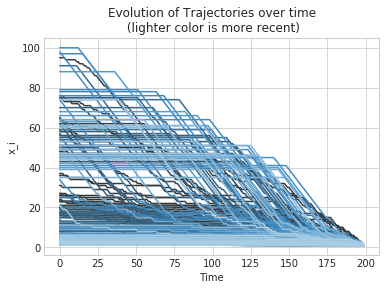

In [163]:
results.plot_all_trajectory_evolution(dimension=0)

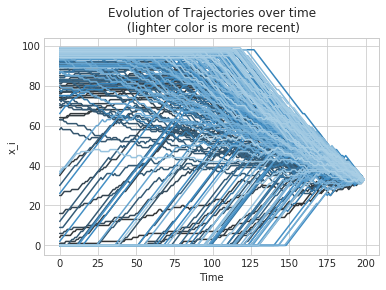

In [164]:
results.plot_all_trajectory_evolution(dimension=1)

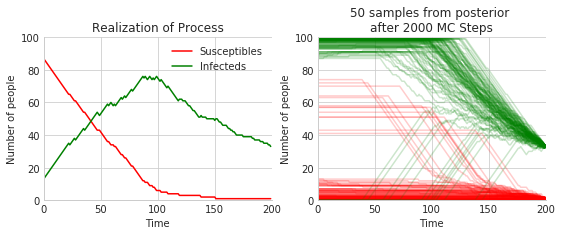

In [165]:
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(121)
ax.plot(sir.true_trajectory[:, 0], label='Susceptibles', color='r')
ax.plot(sir.true_trajectory[:, 1], label='Infecteds', color='g')
ax.set_xlabel('Time')
ax.set_ylabel('Number of people')
ax.legend()
ax.set_ylim(0, 100)
ax.set_xlim(0, 200)
ax.set_title('Realization of Process')

ax = fig.add_subplot(122)
for trajectory in results.all_trajectories()[-100:]:
    ax.plot(np.arange(200-trajectory.shape[0]+1, 201, 1), trajectory[:, 0], label='Susceptibles', color='r', alpha=0.2)
    ax.plot(np.arange(200-trajectory.shape[0]+1, 201, 1), trajectory[:, 1], label='infecteds', color='g', alpha=0.2)
ax.set_xlabel('Time')
ax.set_ylabel('Number of people')
ax.set_ylim(0, 100)
ax.set_xlim(0, 200)
ax.set_title('50 samples from posterior \nafter 2000 MC Steps')
sns.despine()

In [143]:
state = np.array([[5, 80, 0.9]], dtype=np.float32)
sir.transition_prob(state), nn.Softmax()(fn_approximator(torch.autograd.Variable(torch.from_numpy(state)))).data.numpy()

/home/ml/zahmed8/zaf-tmp/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


(array([[0.33333335, 0.66666665, 0.        ]]),
 array([[0.10277657, 0.6808284 , 0.21639507]], dtype=float32))

In [16]:
timesteps = 200
xranges = 100
t, x = np.meshgrid(range(0, timesteps), range(0, xranges + 1))
list(zip(x.reshape(-1), t.reshape(-1)/t))

# for x_ in x[:, 0]:
#     vector_grid_y_arrows_t = [[] for _ in list_of_proposals]
#     for t_ in t[0, :]:
#         for proposal, vector_grid_y_arrows_t_i in zip(list_of_proposals, vector_grid_y_arrows_t):
#             if neural_network:
#                 feed_time = proposal.fn_approximator.Input.weight.size()[1] == 2
#                 vector_grid_y_arrows_t_i.append(conduct_draws_nn(proposal, float(x_), t_ / timesteps, feed_time=feed_time))
#             else:
#                 vector_grid_y_arrows_t_i.append(conduct_draws(proposal, float(x_), t_))
#     for i in range(len(vector_grid_y_arrows_t)):
#         vector_grid_y_arrows[i].append(vector_grid_y_arrows_t[i])

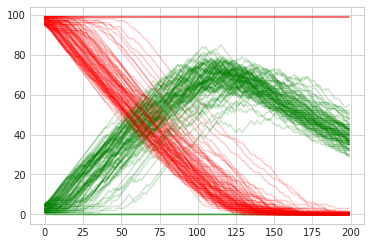

In [121]:
for i in range(100):
    trajectory = sir.simulate()
    plt.plot(trajectory[:, 0], label='Susceptibles', color='r', alpha=0.2)
    plt.plot(trajectory[:, 1], label='infecteds', color='g', alpha=0.2)
#     plt.plot(sir.population_size - trajectory[:, 0] - trajectory[:, 1], label='recoveries', color='b', alpha=0.2)
